In [ ]:
pip install tensorflow tensorflow scikit-learn matplotlib

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, SimpleRNN, Dropout, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Market_Data.csv to Market_Data.csv


In [ ]:
# Load the data where the first row contains headers
correct_data = pd.read_csv('Market_Data.csv', header=0)

# Display the DataFrame
correct_data.head()

# Print all column names
print("Columns in the DataFrame:", correct_data.columns)

# Ensure the Date column is correctly parsed and available
if 'Date' in correct_data.columns:
    # Convert the 'Date' column to datetime
    correct_data['Date'] = pd.to_datetime(correct_data['Date'], errors='coerce')

    # Print the first few rows to verify
    print("Data with Date column:")
    print(correct_data.head())

Columns in the DataFrame: Index(['Date', 'PX_LAST', 'Return', 'SMA_15', 'SMA_45', 'RSI', 'MACD',
       'Bollinger_Mid', 'Bollinger_Upper'],
      dtype='object')
Data with Date column:
        Date   PX_LAST    Return       SMA_15       SMA_45        RSI  \
0 2010-08-03  23047.31  0.005383  23024.53667  22617.92667  57.169175   
1 2010-09-03  23196.20  0.006460  23033.52267  22670.31111  61.521681   
2 2010-10-03  23412.41  0.009321  23056.73067  22724.88289  66.798115   
3 2010-11-03  23666.33  0.010846  23099.61267  22778.66333  71.705329   
4 2010-12-03  24141.72  0.020087  23168.04400  22837.71911  78.201260   

         MACD  Bollinger_Mid  Bollinger_Upper  
0  125.086460     23019.0665      23159.80275  
1  131.623248     23035.7010      23177.60081  
2  152.492205     23055.7240      23272.05936  
3  187.360451     23082.5185      23425.12709  
4  250.466564     23137.5985      23711.41681  


In [ ]:
# Strip leading and trailing spaces from column names
correct_data.columns =correct_data.columns.str.strip()

# Preprocess the data
correct_data['Date'] = pd.to_datetime(correct_data['Date'], format='%Y-%m-%d', errors='raise')
correct_data = correct_data.sort_values('Date')
correct_data.set_index('Date', inplace=True)

# Drop rows with NaN values resulting from technical indicators calculation
correct_data = correct_data.dropna()

# Define features for scaling
features = ['PX_LAST', 'Return', 'SMA_15', 'SMA_45', 'RSI', 'MACD', 'Bollinger_Mid', 'Bollinger_Upper']

# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(correct_data[features])

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - loss: 0.0097 - val_loss: 0.0093
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - loss: 0.0014 - val_loss: 0.0027
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - loss: 0.0170 - val_loss: 0.0137
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0027 - val_loss: 0.0100
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - loss: 0.0022 - val_loss: 0.0093
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - l

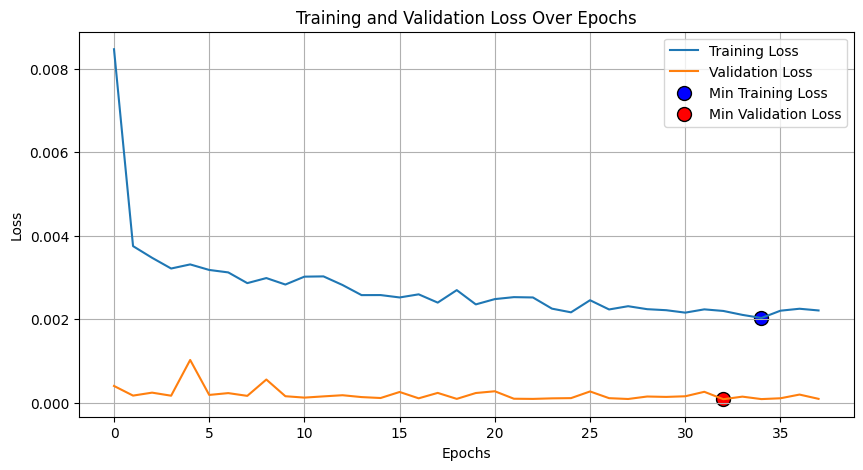

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
MAE: 0.01573346537524883
MSE: 0.0007337485675910234
RMSE: 0.027087793701057003
MAPE: 54.39630854462557
R-Squared: 0.9849732766750364
MAE: 1352.927925011719
MSE: 5425600.479333252
RMSE: 2329.2918407389943
MAPE: 2.0181142803605603
R-Squared: 0.9849732766750364


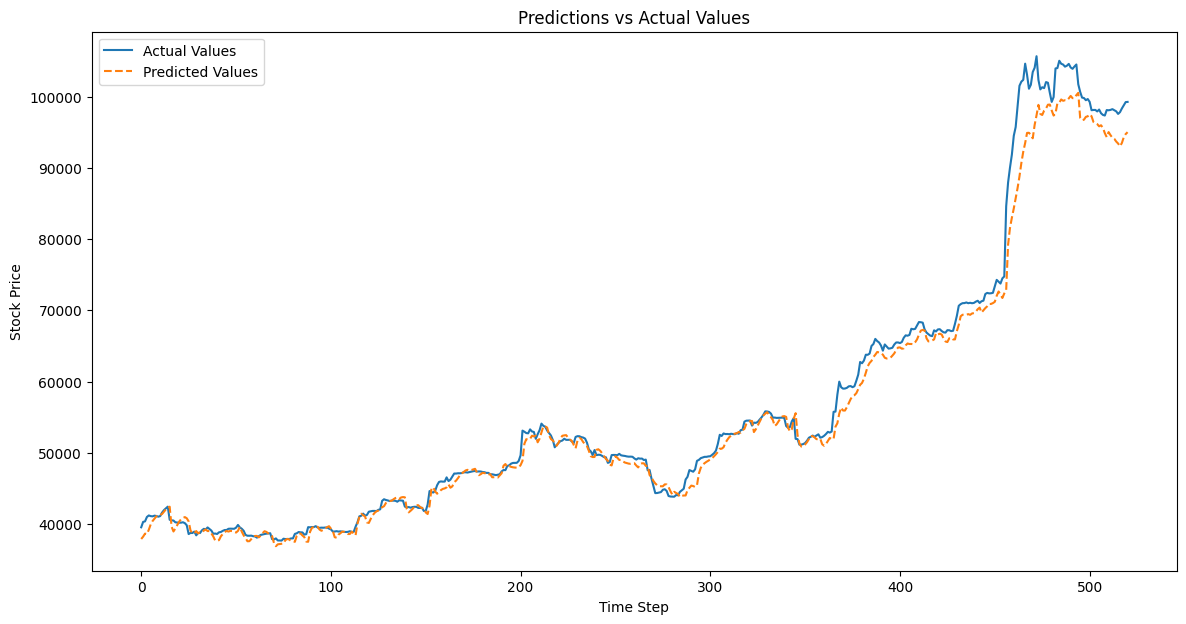

In [ ]:
# Prepare dataset for LSTM
def create_lstm_dataset(data, time_step=60):
    X, Y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step)])
        Y.append(data[i + time_step, 0])  # Predicting 'PX_LAST'
    return np.array(X), np.array(Y)

X, Y = create_lstm_dataset(scaled_data)

# Define the split index for final testing
test_split_index = int(len(X) * 0.85)

# Split the data into train/validation and test sets
X_train_val, X_test = X[:test_split_index], X[test_split_index:]
Y_train_val, Y_test = Y[:test_split_index], Y[test_split_index:]

# Reshape data
X = X.reshape(X.shape[0], X.shape[1], len(features))

# Time Series Cross-Validation setup on the training/validation set
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

final_train_loss = []
final_val_loss = []

# Define a callback for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Time series cross-validation loop
for train_index, val_index in tscv.split(X_train_val):
    X_train, X_val = X_train_val[train_index], X_train_val[val_index]
    Y_train, Y_val = Y_train_val[train_index], Y_train_val[val_index]

    # Define the LSTM model
    model = Sequential([
        Input(shape=(60, len(features))),
        LSTM(units=60, return_sequences=True),
        Dropout(0.2),
        LSTM(units=60, return_sequences=False),
        Dropout(0.2),
        Dense(units=1)
    ])

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, Y_train, epochs=50, batch_size=64, validation_data=(X_val, Y_val), verbose=1, callbacks=[early_stopping])

    # Append the last loss values
    final_train_loss.append(history.history['loss'][-1])
    final_val_loss.append(history.history['val_loss'][-1])

# Calculate average losses from cross-validation
average_train_loss = np.mean(final_train_loss)
average_val_loss = np.mean(final_val_loss)

print("Average Training Loss:", average_train_loss)
print("Average Validation Loss:", average_val_loss)

# Evaluate the final model on the test set
test_loss = model.evaluate(X_test, Y_test, verbose=1)
print(f'Test Loss: {test_loss}')

# Assuming `history.history['loss']` and `history.history['val_loss']` contain your loss data

train_losses = history.history['loss']
val_losses = history.history['val_loss']

min_train_loss = min(train_losses)
min_val_loss = min(val_losses)
min_train_loss_index = train_losses.index(min_train_loss) + 1  # adding 1 to convert from index to epoch
min_val_loss_index = val_losses.index(min_val_loss) + 1

# Result Summary
results_summary = pd.DataFrame({
    "Metric": ["Training Loss", "Validation Loss"],
    "Minimum Value": [min_train_loss, min_val_loss],
    "Epoch": [min_train_loss_index, min_val_loss_index]
})

print(results_summary)

# Print Result
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.scatter(min_train_loss_index - 1, min_train_loss, color='blue', s=100, edgecolors='black', label='Min Training Loss')
plt.scatter(min_val_loss_index - 1, min_val_loss, color='red', s=100, edgecolors='black', label='Min Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Make predictions
Y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(Y_test, Y_pred)
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((Y_test - Y_pred) / Y_test)) * 100
r2 = r2_score(Y_test, Y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R-Squared: {r2}')


# Inverse scaling to get original values
Y_test_rescaled = scaler.inverse_transform(
    np.concatenate((Y_test.reshape(-1, 1), np.zeros((Y_test.shape[0], len(features) - 1))), axis=1)
)[:, 0]
Y_pred_rescaled = scaler.inverse_transform(
    np.concatenate((Y_pred, np.zeros((Y_pred.shape[0], len(features) - 1))), axis=1)
)[:, 0]

# Calculate evaluation metrics
mae = mean_absolute_error(Y_test_rescaled, Y_pred_rescaled)
mse = mean_squared_error(Y_test_rescaled, Y_pred_rescaled)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((Y_test_rescaled - Y_pred_rescaled) / Y_test_rescaled)) * 100
r2 = r2_score(Y_test_rescaled, Y_pred_rescaled)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')
print(f'R-Squared: {r2}')

# Plot predictions vs actual
plt.figure(figsize=(14, 7))
plt.plot(Y_test_rescaled, label='Actual Values')
plt.plot(Y_pred_rescaled, label='Predicted Values', linestyle='--')
plt.title('Predictions vs Actual Values')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()